# Import packages

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import warnings; warnings.simplefilter('ignore')
import ast
import re
from timeit import default_timer as timer

C:\Users\dom\Anaconda3\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# Functions

In [2]:
#Function that writes to csv
def saveData(x):
    x.to_csv('dataintermediate.csv',index=False)

In [3]:
#find any of specific substrings 
def substringExists(x,strlist):
    """if any of folling values appears return 1"""
    if any(re.findall('|'.join(strlist),x)):
        return 1
    return x

# Data preparation

### Read Data and select columns for Model

In [4]:
df=pd.read_csv('data.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 377185 entries, 0 to 377184
Data columns (total 18 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   status        337267 non-null  object
 1   private pool  4181 non-null    object
 2   propertyType  342452 non-null  object
 3   street        377183 non-null  object
 4   baths         270847 non-null  object
 5   homeFacts     377185 non-null  object
 6   fireplace     103115 non-null  object
 7   city          377151 non-null  object
 8   schools       377185 non-null  object
 9   sqft          336608 non-null  object
 10  zipcode       377185 non-null  object
 11  beds          285903 non-null  object
 12  state         377185 non-null  object
 13  stories       226470 non-null  object
 14  mls-id        24942 non-null   object
 15  PrivatePool   40311 non-null   object
 16  MlsId         310305 non-null  object
 17  target        374704 non-null  object
dtypes: object(18)
memory usa

In [5]:
#First I will use most commonsence properties that might influence the property Price
data=df[['status','private pool','baths','homeFacts','fireplace','schools','sqft','beds','state','stories','PrivatePool','propertyType','target']]

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 377185 entries, 0 to 377184
Data columns (total 13 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   status        337267 non-null  object
 1   private pool  4181 non-null    object
 2   baths         270847 non-null  object
 3   homeFacts     377185 non-null  object
 4   fireplace     103115 non-null  object
 5   schools       377185 non-null  object
 6   sqft          336608 non-null  object
 7   beds          285903 non-null  object
 8   state         377185 non-null  object
 9   stories       226470 non-null  object
 10  PrivatePool   40311 non-null   object
 11  propertyType  342452 non-null  object
 12  target        374704 non-null  object
dtypes: object(13)
memory usage: 37.4+ MB


## HomeFacts

In [7]:
data['homeFacts']=data['homeFacts'].apply(lambda x: ast.literal_eval(x)['atAGlanceFacts'])


In [8]:
#Get Labels for df columns
def getdata(x):
    Labels=list()
    for i in x:
        Labels.append(i['factLabel'])
    return Labels
Labels=getdata(data.homeFacts[1])
Labels

['Year built',
 'Remodeled year',
 'Heating',
 'Cooling',
 'Parking',
 'lotsize',
 'Price/sqft']

In [9]:
#Convert dictionaries per row to appropriate columns in df and extract all the values
for l in Labels:
    data[l]=data['homeFacts'].apply(lambda x: x[Labels.index(l)]['factValue']) 

In [10]:
saveData(data)


## Schools

In [11]:
data=pd.read_csv('dataintermediate.csv')
data['schools']=data['schools'].apply(lambda x: ast.literal_eval(x)[0])

In [12]:
#Extract rating list to schRating column
data['schRating']=data['schools'].apply(lambda x: [n for n in x['rating'] if n != 'NR']) 

In [13]:
def findrating(x):
    '''Function that makes an order in ratings and takes the maximum'''
    l=[0]
    for i in x:
        if (i.find('/')>-1 and i[:i.find('/')]=='None') or i=='NA' or i=='':
            l.append(0)
        elif i.find('/')>-1:
            l.append(int(i[:i.find('/')]))
        else:
            l.append(int(i))
    return max(l)

In [14]:
data['schRating']=data['schRating'].apply(lambda x: findrating(x))

In [15]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 377185 entries, 0 to 377184
Data columns (total 21 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   status          337267 non-null  object 
 1   private pool    4181 non-null    object 
 2   baths           270847 non-null  object 
 3   homeFacts       377185 non-null  object 
 4   fireplace       103115 non-null  object 
 5   schools         377185 non-null  object 
 6   sqft            336608 non-null  object 
 7   beds            285903 non-null  object 
 8   state           377185 non-null  object 
 9   stories         226470 non-null  object 
 10  PrivatePool     40311 non-null   object 
 11  propertyType    342452 non-null  object 
 12  target          374704 non-null  object 
 13  Year built      314811 non-null  object 
 14  Remodeled year  151075 non-null  float64
 15  Heating         267853 non-null  object 
 16  Cooling         253218 non-null  object 
 17  Parking   

### Fill nas in sqft with existing lotsize values

In [16]:
data.lotsize=data.lotsize.str.lower().str.strip()
#Remove all acre substrings and convert the values to float and fill na of sqft with values
data.sqft[(data.sqft.isna()==True)&(data.lotsize.str.contains('acre'))]=data.lotsize[(data.sqft.isna()==True)&(data.lotsize.str.contains('acre'))].str.replace(' acres','').str.replace(',','').str.replace(' acre','').astype(float)*43560.04

In [17]:
#Remove all sq substrings and convert the values to float and fill na of sqft with values
data.sqft[(data.sqft.isna()==True)&(data.lotsize.str.contains('sq'))]=data.lotsize[(data.sqft.isna()==True)&(data.lotsize.str.contains('sq'))].str.replace(' sq. ft.','').str.replace(',','').str.replace(' sqft','').astype(float)*43560.04

## Price/sqft

In [18]:
data['Price/sqft']=data['Price/sqft'].str.lower()

In [19]:
data['Price/sqft']=data['Price/sqft'].str.replace('$',"").str.replace('/sqft','').str.replace(' / sq. ft.','').str.replace(',','')
data['Price/sqft']=data['Price/sqft'].str.replace('no data','0').str.replace('no info','0').str.replace('contact manager','0')

In [20]:
data['Price/sqft'].fillna(0,inplace=True)

In [21]:
data['Price/sqft'].head(10)

0    144
1    159
2    965
3    371
4      0
5    233
6    120
7     57
8     68
9    162
Name: Price/sqft, dtype: object

In [22]:
data['Price/sqft']=data['Price/sqft'].astype(int)

In [24]:
data['Price/sqft'].value_counts(normalize=True,bins=5)

(-5950.001, 1190000.0]    0.999963
(1190000.0, 2380000.0]    0.000024
(4760000.0, 5950000.0]    0.000011
(2380000.0, 3570000.0]    0.000003
(3570000.0, 4760000.0]    0.000000
Name: Price/sqft, dtype: float64

In [25]:
data['Price/sqft'][(data['Price/sqft']>0)]=np.log(data['Price/sqft'][(data['Price/sqft']>0)])

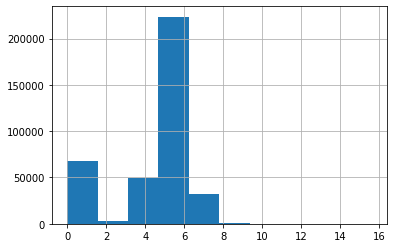

In [26]:
data['Price/sqft'].hist()

In [27]:
data['Price/sqft'].value_counts(normalize=True,bins=5)

(3.12, 6.24]        0.724448
(-0.0166, 3.12]     0.187728
(6.24, 9.359]       0.087535
(9.359, 12.479]     0.000159
(12.479, 15.599]    0.000130
Name: Price/sqft, dtype: float64

### Price of the Property (target) 

In [28]:
#find symbols that are not numbers to replace

symbollist=data.target.str.findall(r'\D').value_counts().reset_index()['index']
s=list()
for i in symbollist:
    s=s+i
s=list(set(s))
s=''.join(s)
s

'/, $-+mo'

In [29]:
#Function that First remove ",","+","/mo" from all string values then If the string value is a range - take the average
#Function returns for strings it's numeric value
def clean_currency(x):
    """replace redundent symbols"""
    if isinstance(x, str):
        x=x.replace('$','').replace(',','').replace('+','').replace('/mo','')
      
    #for values that appears as range take the average
    if isinstance(x, str) and x.find(' - ')>0:
        a=x.find(' - ')
        return((float(x[:a])+float(x[a+3:]))/2)  
    return(float(x))

In [30]:
data['target'] = data['target'].apply(clean_currency)
data=data.rename(columns={'target':'Price'})

In [31]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 377185 entries, 0 to 377184
Data columns (total 21 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   status          337267 non-null  object 
 1   private pool    4181 non-null    object 
 2   baths           270847 non-null  object 
 3   homeFacts       377185 non-null  object 
 4   fireplace       103115 non-null  object 
 5   schools         377185 non-null  object 
 6   sqft            362944 non-null  object 
 7   beds            285903 non-null  object 
 8   state           377185 non-null  object 
 9   stories         226470 non-null  object 
 10  PrivatePool     40311 non-null   object 
 11  propertyType    342452 non-null  object 
 12  Price           374704 non-null  float64
 13  Year built      314811 non-null  object 
 14  Remodeled year  151075 non-null  float64
 15  Heating         267853 non-null  object 
 16  Cooling         253218 non-null  object 
 17  Parking   

## sqft

In [32]:
#use Area data for filling NAs for sqft
values=data['beds'][data.beds.str.contains('sqft')==True]
valuesA=data['beds'][data.beds.str.contains('acres')==True]
data['sqft'][data.beds.str.contains('sqft')==True]=values
data['sqft'][data.beds.str.contains('acres')==True]=valuesA
data[['beds','sqft']][(data.beds.str.contains('sqft|acres')==True)]
data['beds'][data.beds.str.contains('sqft|arcres')==True]='None'

In [33]:
data.sqft[data.sqft.str.contains(' sqft|,')==True]=data.sqft[data.sqft.str.contains(' sqft|,')==True].str.replace(' sqft','').str.replace(',','')
data.sqft[data.sqft.str.contains('acre')==True]=data.sqft[data.sqft.str.contains('acre')==True].str.replace(' acres','').astype(float)*43560.04
data.sqft[(data.sqft.str.contains('\D')==True)&(data.sqft.isna()==False)]=data.sqft[(data.sqft.str.contains('\D')==True)&(data.sqft.isna()==False)].str.replace('\D','')
#fill blank with mean of non blank
data.sqft[(data.sqft.isna()==False)&(data.sqft=='')]=data.sqft[(data.sqft.isna()==False)&(data.sqft!='')].astype(float).mean()
data.sqft[(data.sqft.isna()==False)]=data.sqft[(data.sqft.isna()==False)].astype(float)

In [34]:
#Group data according to property type and take the average area for each property type for NA
Area=data[['sqft','propertyType']]
Area['sqft']=Area['sqft'][Area.sqft.isna()==False].astype(float)
Area=Area[Area.sqft.isna()==False].groupby(by='propertyType').mean().reset_index()
Area.sqft=Area.sqft.round(decimals=0)
data.sqft[data.sqft.isna()==True]=data[data.sqft.isna()==True].merge(Area, on='propertyType', how='left').sqft_y


### Use Price, sqft and Price/sqft to fill na's

In [35]:
#replace sqft nas with [Price]/[Price/sqft]
data1=data[['Price/sqft','sqft','Price']][(data.sqft.isna()==True)&(data['Price/sqft'].isna()==False)&(data.Price.isna()==False)&(data['Price/sqft']!='none')]
data1.sqft=data1.Price/data1['Price/sqft']
data['sqft'].iloc[data1.index]=data1.sqft

In [36]:
#replace Price nas with [sqft]*[Price/sqft]
data1=data[['Price/sqft','sqft','Price']][((data.Price.isna()==True)&data.sqft.isna()==False)&(data['Price/sqft'].isna()==False)&(data['Price/sqft']!='none')]
data1.Price=data1.sqft*data1['Price/sqft']
data['Price'].iloc[data1.index]=data1.Price
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 377185 entries, 0 to 377184
Data columns (total 21 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   status          337267 non-null  object 
 1   private pool    4181 non-null    object 
 2   baths           270847 non-null  object 
 3   homeFacts       377185 non-null  object 
 4   fireplace       103115 non-null  object 
 5   schools         377185 non-null  object 
 6   sqft            377065 non-null  object 
 7   beds            285903 non-null  object 
 8   state           377185 non-null  object 
 9   stories         226470 non-null  object 
 10  PrivatePool     40311 non-null   object 
 11  propertyType    342452 non-null  object 
 12  Price           366378 non-null  object 
 13  Year built      314811 non-null  object 
 14  Remodeled year  151075 non-null  float64
 15  Heating         267853 non-null  object 
 16  Cooling         253218 non-null  object 
 17  Parking   

In [37]:
data.drop(['Price/sqft','lotsize'],axis=1,inplace=True)

### Get rid of the rows where Price and sqft is NA

In [38]:
data.dropna(subset=['sqft'],axis=0,inplace=True)
data.dropna(subset=['Price'],axis=0,inplace=True)

In [39]:
data.sqft=data.sqft.astype(float)
data.Price=data.Price.astype(float)

In [40]:
data.Price.describe()

count    3.663780e+05
mean     1.983235e+06
std      5.627604e+07
min      0.000000e+00
25%      5.125764e+03
50%      8.503574e+03
75%      1.273311e+04
max      2.752820e+09
Name: Price, dtype: float64

In [41]:
data.Price.value_counts(normalize=True,bins=10)

(-2752820.293, 275282029.244]       0.998619
(1376410146.219, 1651692175.463]    0.000319
(1651692175.463, 1926974204.707]    0.000259
(1101128116.976, 1376410146.219]    0.000216
(825846087.732, 1101128116.976]     0.000158
(1926974204.707, 2202256233.951]    0.000142
(550564058.488, 825846087.732]      0.000104
(275282029.244, 550564058.488]      0.000101
(2202256233.951, 2477538263.195]    0.000063
(2477538263.195, 2752820292.439]    0.000019
Name: Price, dtype: float64

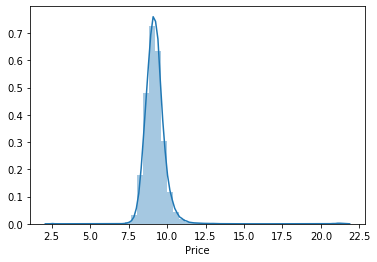

In [42]:
sns.distplot(np.log(data.Price[(data.Price >0)&(data.Price <=34500126672.528)]))

In [43]:
#get rid of exceptions data
data.drop(data.Price[(data.Price <=0)|(data.Price >34500126672.528)].index,axis=0,inplace=True)

In [44]:
#normalizing Price
data.Price=np.log(data.Price)

In [45]:
#data.to_csv('dataintermediate.csv',index=False)
saveData(data)

In [46]:
data=pd.read_csv('dataintermediate.csv')

## Year built and remodeled

In [47]:
data=pd.read_csv('dataintermediate.csv')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 310021 entries, 0 to 310020
Data columns (total 19 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   status          279884 non-null  object 
 1   private pool    3721 non-null    object 
 2   baths           249213 non-null  object 
 3   homeFacts       310021 non-null  object 
 4   fireplace       98286 non-null   object 
 5   schools         310021 non-null  object 
 6   sqft            310021 non-null  float64
 7   beds            261396 non-null  object 
 8   state           310021 non-null  object 
 9   stories         211796 non-null  object 
 10  PrivatePool     38521 non-null   object 
 11  propertyType    293227 non-null  object 
 12  Price           310021 non-null  float64
 13  Year built      292469 non-null  object 
 14  Remodeled year  140359 non-null  float64
 15  Heating         246349 non-null  object 
 16  Cooling         238643 non-null  object 
 17  Parking   

In [48]:
#put indexes of str and num values in to variables
stri=data['Year built'][data['Year built'].str.contains('\D')==True].index
numi=data['Year built'][data['Year built'].str.contains('\D')==False].index

In [49]:
#replace exeptions where there is no sence (smaller than 0 or bigger than 2020) by No Data
iyearexp=data['Year built'].iloc[numi].astype('int64')[(data['Year built'].iloc[numi].astype('int64')<0)|(data['Year built'].iloc[numi].astype('int64')>2020)].index
data['Year built'].iloc[iyearexp]='No Data'
numi=data['Year built'][data['Year built'].str.contains('\D')==False].index
stri=data['Year built'][data['Year built'].str.contains('\D')==True].index

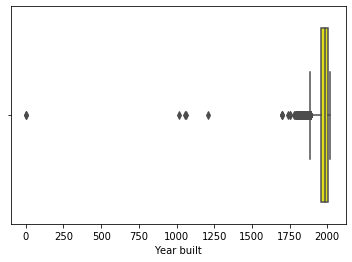

In [50]:
#Check if there are more exeptions
sns.boxplot(data['Year built'].iloc[numi].astype('int64'), color='yellow');

In [51]:
#Drop more exeptions values that smaller than 1500 -> update number indexes value
iyearexp=data['Year built'].iloc[numi].astype('int64')[(data['Year built'].iloc[numi].astype('int64')<1500)|(data['Year built'].iloc[numi].astype('int64')>2020)].index
data['Year built'].iloc[iyearexp]='No Data'
numi=data['Year built'][data['Year built'].str.contains('\D')==False].index
stri=data['Year built'][data['Year built'].str.contains('\D')==True].index

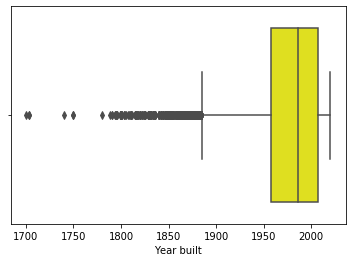

In [52]:
sns.boxplot(data['Year built'].iloc[numi].astype('int64'), color='yellow');

In [53]:
#convert numeric data to integer
data['Year built'].iloc[numi]=data['Year built'].iloc[numi].astype(int)

In [54]:
#replace string data to mean of numeric data
data['Year built'].iloc[stri]=int(round(data['Year built'].iloc[numi].mean(),0))

In [55]:
#fill nas with the mean of numeric values
data['Year built'].fillna(int(round(data['Year built'].iloc[numi].mean(),0)),inplace=True)

In [56]:
data['Year built'].describe()

count    310021.000000
mean       1980.172621
std          32.364232
min        1700.000000
25%        1960.000000
50%        1983.000000
75%        2007.000000
max        2020.000000
Name: Year built, dtype: float64

In [57]:
data['Remodeled year'].fillna(data['Remodeled year'].notnull().mean(),inplace=True)
data['Remodeled year']=data['Remodeled year'].astype(int)

### Status

In [58]:
data.status=data.status.str.lower()
status=data.status
status=status.value_counts(normalize=True).reset_index()
status
#according to next summary I would use only for sale, active, accepted for status(that are 91% of overall amount), the rest will be dropped

,index,status
0,for sale,0.637989
1,active,0.282321
2,new construction,0.018300
3,foreclosure,0.015503
4,pending,0.015092
...,...,...
136,under contract taking back up offers,0.000004
137,"pending, continue to show",0.000004
138,reactivated,0.000004
139,contingent - sale of home,0.000004


In [59]:
strlist=['for sale','active','accepted']
status['newStatus']=status['index'].apply(lambda x: substringExists(x,strlist))
nstatus=status.groupby('newStatus').sum().reset_index()
nstatus

,newStatus,status
0,1,0.924769
1,apartment for rent,0.000021
2,auction,0.000029
3,back on market,0.000372
4,backup contract,0.000021
...,...,...
119,under contract - show,0.000029
120,under contract backups,0.000890
121,under contract show,0.003805
122,under contract taking back up offers,0.000004


In [60]:
#create list of statuses that are not relevant and then drop them from df
nstatus=status[status['newStatus']!=1]['newStatus']
nstatus.tolist()

['new construction',
 'foreclosure',
 'pending',
 'p',
 'under contract show',
 'under contract   showing',
 'under contract',
 'contingent',
 'new',
 'price change',
 'recently sold',
 'under contract backups',
 'contingent finance and inspection',
 'pending continue to show',
 'option pending',
 'back on market',
 'contingent show',
 'pending taking backups',
 'option contract',
 'foreclosed',
 'pending with contingencies',
 'c',
 'pi',
 'contract p',
 'p pending sale',
 'contract contingent on buyer sale',
 'c continue show',
 'pending - taking backups',
 'closed',
 'pending inspection',
 'contingent take backup',
 'offer pending signature',
 'pending in',
 'contingent   show',
 'coming soon: nov 29.',
 'listing extended',
 'pending w/insp finance',
 'contingency contract',
 'contingent escape',
 'ct insp - inspection contingency',
 'u under contract',
 'auction',
 'coming soon: dec 6.',
 'under contract - show',
 'coming soon: dec 5.',
 'backup contract',
 'coming soon: dec 4.',
 '

In [61]:
data.drop(data[data['status'].isin(nstatus)==True].index.values.tolist(),inplace=True)
data=data.reset_index()
data.drop(['index'],axis=1,inplace=True)
data.drop(['status'],axis=1,inplace=True)
data.head()

,private pool,baths,homeFacts,fireplace,schools,sqft,beds,state,stories,PrivatePool,propertyType,Price,Year built,Remodeled year,Heating,Cooling,Parking,schRating
0,NaN,3.5,"[{'factValue': '2019', 'factLabel': 'Year buil...",Gas Logs,"{'rating': ['4', '4', '7', 'NR', '4', '7', 'NR...",2900.0,4,NC,NaN,NaN,Single Family Home,9.575848,2019,0,"Central A/C, Heat Pump",NaN,NaN,7
1,NaN,3 Baths,"[{'factValue': '2019', 'factLabel': 'Year buil...",NaN,"{'rating': ['4/10', 'None/10', '4/10'], 'data'...",1947.0,3 Beds,WA,2.0,NaN,single-family home,9.197170,2019,0,NaN,NaN,NaN,4
2,NaN,2 Baths,"[{'factValue': '1961', 'factLabel': 'Year buil...",yes,"{'rating': ['8/10', '4/10', '8/10'], 'data': {...",3000.0,3 Beds,CA,1.0,yes,single-family home,9.933841,1961,1967,Forced Air,Central,Attached Garage,8
3,NaN,8 Baths,"[{'factValue': '2006', 'factLabel': 'Year buil...",yes,"{'rating': ['9/10', '9/10', '10/10', '9/10'], ...",6457.0,5 Beds,TX,3.0,NaN,single-family home,10.550615,2006,2006,Forced Air,Central,Detached Garage,10
4,NaN,NaN,"[{'factValue': '1920', 'factLabel': 'Year buil...",NaN,"{'rating': [], 'data': {'Distance': [], 'Grade...",897.0,2 Beds,PA,2.0,NaN,townhouse,8.494862,1920,0,Forced Air,Central,NaN,0


### Private Pool

In [62]:
data['PrivatePool']=data['PrivatePool'].str.lower()
data['private pool']=data['private pool'].str.lower()

In [63]:
# Replace 'yes' with 1 and unufy "private pool" and PrivatePool and replace NA with 0
data[['private pool','PrivatePool']]=data[['private pool','PrivatePool']].replace(to_replace=['yes'],value=1)
data['PrivatePool']=data['PrivatePool'].fillna(data['private pool'])
data['PrivatePool']=data['PrivatePool'].fillna(0)
data=data.drop(['private pool'],axis=1)


In [64]:
data.PrivatePool=data.PrivatePool.astype(int)
data.PrivatePool.value_counts()

0    247446
1     41519
Name: PrivatePool, dtype: int64

In [65]:
data.head()

,baths,homeFacts,fireplace,schools,sqft,beds,state,stories,PrivatePool,propertyType,Price,Year built,Remodeled year,Heating,Cooling,Parking,schRating
0,3.5,"[{'factValue': '2019', 'factLabel': 'Year buil...",Gas Logs,"{'rating': ['4', '4', '7', 'NR', '4', '7', 'NR...",2900.0,4,NC,NaN,0,Single Family Home,9.575848,2019,0,"Central A/C, Heat Pump",NaN,NaN,7
1,3 Baths,"[{'factValue': '2019', 'factLabel': 'Year buil...",NaN,"{'rating': ['4/10', 'None/10', '4/10'], 'data'...",1947.0,3 Beds,WA,2.0,0,single-family home,9.197170,2019,0,NaN,NaN,NaN,4
2,2 Baths,"[{'factValue': '1961', 'factLabel': 'Year buil...",yes,"{'rating': ['8/10', '4/10', '8/10'], 'data': {...",3000.0,3 Beds,CA,1.0,1,single-family home,9.933841,1961,1967,Forced Air,Central,Attached Garage,8
3,8 Baths,"[{'factValue': '2006', 'factLabel': 'Year buil...",yes,"{'rating': ['9/10', '9/10', '10/10', '9/10'], ...",6457.0,5 Beds,TX,3.0,0,single-family home,10.550615,2006,2006,Forced Air,Central,Detached Garage,10
4,NaN,"[{'factValue': '1920', 'factLabel': 'Year buil...",NaN,"{'rating': [], 'data': {'Distance': [], 'Grade...",897.0,2 Beds,PA,2.0,0,townhouse,8.494862,1920,0,Forced Air,Central,NaN,0


### Bath

In [66]:
data.baths=data.baths.str.lower()
print(f'There are {round(data.baths.isna().sum()/data.baths.count()*100,0)}% missing values')

There are 25.0% missing values


In [67]:
#Leave cells with numbers only for Bath 
data['baths']=data.baths.str.findall(r'\d').str[0]

In [68]:
data['baths'][data.baths.isna()==False]=data['baths'][data.baths.isna()==False].astype(int)

In [69]:
data.baths.value_counts(normalize=True)

2.0    0.443836
3.0    0.280621
4.0    0.109897
1.0    0.090618
5.0    0.039885
6.0    0.017995
7.0    0.009788
8.0    0.004807
9.0    0.002288
0.0    0.000266
Name: baths, dtype: float64

In [70]:
#Group data according to property type and take the average bathrooms for each property type for NA
Baths=data[['baths','propertyType']]
Baths['baths']=Baths['baths'][Baths.baths.isna()==False].astype(int)
Baths=Baths[Baths.baths.isna()==False].groupby(by='propertyType').mean().reset_index()
Baths.baths=Baths.baths.round(decimals=0)
data.baths[data.baths.isna()==True]=data[data.baths.isna()==True].merge(Baths, on='propertyType', how='left').baths_y
data.head()

,baths,homeFacts,fireplace,schools,sqft,beds,state,stories,PrivatePool,propertyType,Price,Year built,Remodeled year,Heating,Cooling,Parking,schRating
0,3,"[{'factValue': '2019', 'factLabel': 'Year buil...",Gas Logs,"{'rating': ['4', '4', '7', 'NR', '4', '7', 'NR...",2900.0,4,NC,NaN,0,Single Family Home,9.575848,2019,0,"Central A/C, Heat Pump",NaN,NaN,7
1,3,"[{'factValue': '2019', 'factLabel': 'Year buil...",NaN,"{'rating': ['4/10', 'None/10', '4/10'], 'data'...",1947.0,3 Beds,WA,2.0,0,single-family home,9.197170,2019,0,NaN,NaN,NaN,4
2,2,"[{'factValue': '1961', 'factLabel': 'Year buil...",yes,"{'rating': ['8/10', '4/10', '8/10'], 'data': {...",3000.0,3 Beds,CA,1.0,1,single-family home,9.933841,1961,1967,Forced Air,Central,Attached Garage,8
3,8,"[{'factValue': '2006', 'factLabel': 'Year buil...",yes,"{'rating': ['9/10', '9/10', '10/10', '9/10'], ...",6457.0,5 Beds,TX,3.0,0,single-family home,10.550615,2006,2006,Forced Air,Central,Detached Garage,10
4,3,"[{'factValue': '1920', 'factLabel': 'Year buil...",NaN,"{'rating': [], 'data': {'Distance': [], 'Grade...",897.0,2 Beds,PA,2.0,0,townhouse,8.494862,1920,0,Forced Air,Central,NaN,0


In [71]:
#Group data according to bedrooms and take the average bathrooms for each bedroom number for NA
BathsBeds=data[['baths','beds']]
BathsBeds['baths']=BathsBeds['baths'][BathsBeds.baths.isna()==False].astype(int)
BathsBeds=BathsBeds[BathsBeds.baths.isna()==False].groupby(by='beds').mean().reset_index()
BathsBeds.baths=BathsBeds.baths.round(decimals=0)
data.baths[data.baths.isna()==True]=data[data.baths.isna()==True].merge(BathsBeds, on='beds', how='left').baths_y
data.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 288965 entries, 0 to 288964
Data columns (total 17 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   baths           239215 non-null  object 
 1   homeFacts       288965 non-null  object 
 2   fireplace       91405 non-null   object 
 3   schools         288965 non-null  object 
 4   sqft            288965 non-null  float64
 5   beds            241524 non-null  object 
 6   state           288965 non-null  object 
 7   stories         196977 non-null  object 
 8   PrivatePool     288965 non-null  int32  
 9   propertyType    272280 non-null  object 
 10  Price           288965 non-null  float64
 11  Year built      288965 non-null  int64  
 12  Remodeled year  288965 non-null  int32  
 13  Heating         230834 non-null  object 
 14  Cooling         224104 non-null  object 
 15  Parking         173853 non-null  object 
 16  schRating       288965 non-null  int64  
dtypes: float64

In [72]:
#check if some values can be taken from beds column
data['beds'][(data.beds.str.contains('Bath'))&(data.beds.isna()==False)&(data.baths.isna()==True)]

686       Baths
756       Baths
1057      Baths
1443      Baths
1733      Baths
          ...  
287645    Baths
287820    Baths
288301    Baths
288423    Baths
288550    Baths
Name: beds, Length: 876, dtype: object

In [73]:
#beds columns has values that contains baths, replace NA with 1 for bath and 2 for baths
data['beds'][(data.beds=='Bath')&(data.beds.isna()==False)&(data.baths.isna()==True)]=1
data['beds'][(data.beds=='Baths')&(data.beds.isna()==False)&(data.baths.isna()==True)]=2
data['baths'][(data.beds.str.contains('Bath'))&(data.beds.isna()==False)&(data.baths.isna()==True)]=1

In [74]:
#Group data according to sqft and take the average bathrooms for each area for NA
BathsArea=data[['baths','sqft']]
BathsArea['baths']=BathsArea['baths'][BathsArea.baths.isna()==False].astype(int)
BathsArea=BathsArea[BathsArea.baths.isna()==False].groupby(by='sqft').mean().reset_index()
BathsArea.baths=BathsArea.baths.round(decimals=0)
data.baths[data.baths.isna()==True]=data[data.baths.isna()==True].merge(BathsArea, on='sqft', how='left').baths_y
data.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 288965 entries, 0 to 288964
Data columns (total 17 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   baths           240953 non-null  object 
 1   homeFacts       288965 non-null  object 
 2   fireplace       91405 non-null   object 
 3   schools         288965 non-null  object 
 4   sqft            288965 non-null  float64
 5   beds            241524 non-null  object 
 6   state           288965 non-null  object 
 7   stories         196977 non-null  object 
 8   PrivatePool     288965 non-null  int32  
 9   propertyType    272280 non-null  object 
 10  Price           288965 non-null  float64
 11  Year built      288965 non-null  int64  
 12  Remodeled year  288965 non-null  int32  
 13  Heating         230834 non-null  object 
 14  Cooling         224104 non-null  object 
 15  Parking         173853 non-null  object 
 16  schRating       288965 non-null  int64  
dtypes: float64

In [75]:
data.baths.fillna(1,inplace=True)
data.baths=data.baths.astype(int)

In [76]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 288965 entries, 0 to 288964
Data columns (total 17 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   baths           288965 non-null  int32  
 1   homeFacts       288965 non-null  object 
 2   fireplace       91405 non-null   object 
 3   schools         288965 non-null  object 
 4   sqft            288965 non-null  float64
 5   beds            241524 non-null  object 
 6   state           288965 non-null  object 
 7   stories         196977 non-null  object 
 8   PrivatePool     288965 non-null  int32  
 9   propertyType    272280 non-null  object 
 10  Price           288965 non-null  float64
 11  Year built      288965 non-null  int64  
 12  Remodeled year  288965 non-null  int32  
 13  Heating         230834 non-null  object 
 14  Cooling         224104 non-null  object 
 15  Parking         173853 non-null  object 
 16  schRating       288965 non-null  int64  
dtypes: float64

### Beds

In [77]:
data.beds=data.beds.str.lower()
print(f'There are {round(data.beds.isna().sum()/data.baths.count()*100,0)}% of missing values')

There are 17.0% of missing values


In [78]:
data.beds.value_counts(normalize=True)

3 beds    0.206235
4 beds    0.139324
3         0.102615
2 beds    0.101044
4         0.067676
            ...   
15.0      0.000004
13.0      0.000004
75        0.000004
15 bd     0.000004
46 bd     0.000004
Name: beds, Length: 133, dtype: float64

In [79]:
#leave numbers only for Beds
data['beds']=data.beds.str.replace(' beds','').str.replace(' bd','')
data['beds']=data.beds.str.replace('baths','2')
data['beds']=data.beds.str.replace('bath','1')
data.beds[(data.beds.str.contains('\D')==True)&(data.beds.isna()==False)].value_counts(normalize=True)

3.0                                                                                                                           0.423484
4.0                                                                                                                           0.287052
2.0                                                                                                                           0.127847
5.0                                                                                                                           0.076836
--                                                                                                                            0.031501
1.0                                                                                                                           0.023625
6.0                                                                                                                           0.017595
7.0                                                    

In [80]:
data['beds'][data.beds.str.contains('sqft|acres|acre| |--')==True]=0


In [81]:
data['beds'][data.beds.str.contains('2 bedrooms')==True]=2
data['beds'][data.beds.str.contains('3 or more bedrooms')==True]=3
data['beds'][data.beds.str.contains('based on redfin')==True]=1

In [82]:
data['beds']=data['beds'][(data.beds.isna()==False)&(data.beds!='none')].astype(float)


In [83]:
#Group data according to property type and take the average area for each property type for NA
Beds=data[['beds','propertyType']]
Beds['beds']=Beds['beds'][(Beds.beds.isna()==False)&(Beds.beds!='none')].astype(float)
Beds=Beds.groupby(by='propertyType').mean().reset_index()
Beds.beds=Beds.beds.round(decimals=0)
data=data.merge(Beds, on='propertyType', how='left')

In [84]:
data['beds_x'].fillna(data.beds_y,inplace=True)
data['beds_x'][data.beds_x=='none']=data.beds_y
data.beds_x.fillna(data.beds_x.mean(),inplace=True)
data.drop('beds_y',axis=1,inplace=True)
data=data.rename(columns={'beds_x':'beds'})
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 288965 entries, 0 to 288964
Data columns (total 17 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   baths           288965 non-null  int32  
 1   homeFacts       288965 non-null  object 
 2   fireplace       91405 non-null   object 
 3   schools         288965 non-null  object 
 4   sqft            288965 non-null  float64
 5   beds            288965 non-null  float64
 6   state           288965 non-null  object 
 7   stories         196977 non-null  object 
 8   PrivatePool     288965 non-null  int32  
 9   propertyType    272280 non-null  object 
 10  Price           288965 non-null  float64
 11  Year built      288965 non-null  int64  
 12  Remodeled year  288965 non-null  int32  
 13  Heating         230834 non-null  object 
 14  Cooling         224104 non-null  object 
 15  Parking         173853 non-null  object 
 16  schRating       288965 non-null  int64  
dtypes: float64

In [85]:
data.beds.value_counts(normalize=True,bins=10)

(-0.145, 14.4]    0.999100
(14.4, 28.8]      0.000747
(28.8, 43.2]      0.000090
(43.2, 57.6]      0.000038
(72.0, 86.4]      0.000014
(86.4, 100.8]     0.000007
(129.6, 144.0]    0.000003
(115.2, 129.6]    0.000000
(100.8, 115.2]    0.000000
(57.6, 72.0]      0.000000
Name: beds, dtype: float64

In [86]:
data=data.drop(data.beds[data.beds>15].index)

In [87]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 288737 entries, 0 to 288964
Data columns (total 17 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   baths           288737 non-null  int32  
 1   homeFacts       288737 non-null  object 
 2   fireplace       91376 non-null   object 
 3   schools         288737 non-null  object 
 4   sqft            288737 non-null  float64
 5   beds            288737 non-null  float64
 6   state           288737 non-null  object 
 7   stories         196855 non-null  object 
 8   PrivatePool     288737 non-null  int32  
 9   propertyType    272052 non-null  object 
 10  Price           288737 non-null  float64
 11  Year built      288737 non-null  int64  
 12  Remodeled year  288737 non-null  int32  
 13  Heating         230686 non-null  object 
 14  Cooling         223976 non-null  object 
 15  Parking         173706 non-null  object 
 16  schRating       288737 non-null  int64  
dtypes: float64

### Create feature baths per bedroom

In [88]:
data['baths'][data['baths']<1]=1
data['beds'][data['beds']<1]=1
data['baths/bed']=data['beds']/data['baths']

In [89]:
#data.to_csv('dataintermediate.csv',index=False)
saveData(data)

### Fireplace

In [90]:
data=pd.read_csv('dataintermediate.csv')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 288737 entries, 0 to 288736
Data columns (total 18 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   baths           288737 non-null  int64  
 1   homeFacts       288737 non-null  object 
 2   fireplace       91376 non-null   object 
 3   schools         288737 non-null  object 
 4   sqft            288737 non-null  float64
 5   beds            288737 non-null  float64
 6   state           288737 non-null  object 
 7   stories         196855 non-null  object 
 8   PrivatePool     288737 non-null  int64  
 9   propertyType    272052 non-null  object 
 10  Price           288737 non-null  float64
 11  Year built      288737 non-null  int64  
 12  Remodeled year  288737 non-null  int64  
 13  Heating         230686 non-null  object 
 14  Cooling         223976 non-null  object 
 15  Parking         173706 non-null  object 
 16  schRating       288737 non-null  int64  
 17  baths/bed 

In [91]:
data['fireplace']=data['fireplace'].str.lower()
data.fireplace[data.fireplace.str.contains('fire|yes|gas|burning|stove|frplc')==True]=1
data.fireplace[data.fireplace.str.contains('no|0 ')==True]=0
data.fireplace[(data.fireplace.str.contains('\d')==True)&(data.fireplace.str.contains('0')==False)]=1
data.fireplace[data.fireplace!=1]=0

In [92]:
data.fireplace=data.fireplace.astype(int)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 288737 entries, 0 to 288736
Data columns (total 18 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   baths           288737 non-null  int64  
 1   homeFacts       288737 non-null  object 
 2   fireplace       288737 non-null  int32  
 3   schools         288737 non-null  object 
 4   sqft            288737 non-null  float64
 5   beds            288737 non-null  float64
 6   state           288737 non-null  object 
 7   stories         196855 non-null  object 
 8   PrivatePool     288737 non-null  int64  
 9   propertyType    272052 non-null  object 
 10  Price           288737 non-null  float64
 11  Year built      288737 non-null  int64  
 12  Remodeled year  288737 non-null  int64  
 13  Heating         230686 non-null  object 
 14  Cooling         223976 non-null  object 
 15  Parking         173706 non-null  object 
 16  schRating       288737 non-null  int64  
 17  baths/bed 

### Stories

In [93]:
data.stories=data.stories.str.lower()

In [94]:
data['st1']=data.stories.str.findall(r'\d').str[0]
#data.stories=data.stories[data.st1.isna()==False]
data.stories[(data.st1.isna()==True)&(data.stories.isna()==False)].value_counts()
#data.stories.value_counts()

one                       5455
two                       2420
three or more              538
one story                  296
multi/split                252
                          ... 
two, multi/split             1
multi/split, two             1
bedroom - split plan         1
split entry (bi-level)       1
multi level, tri level       1
Name: stories, Length: 85, dtype: int64

In [95]:
data.stories[data.stories.str.contains('one')==True]=1
data.stories[data.stories.str.contains('two')==True]=2

In [96]:
data.stories=data['st1'][(data.st1.isna()==False)&(data.stories.isna()==False)]

In [97]:
data.drop('st1',axis=1,inplace=True)
data.dropna(subset=['stories'],axis=0,inplace=True)

In [98]:
data.stories=data.stories.astype(int)

In [99]:
data['stories'][data.stories<2]=1
data['stories'][data.stories>1]=2

In [100]:
data.stories.value_counts()

2    94778
1    91677
Name: stories, dtype: int64

In [101]:
#data.to_csv('dataintermediate.csv',index=False)
saveData(data)


### Parking

In [102]:
data=pd.read_csv('dataintermediate.csv')
data.Parking.value_counts()

Attached Garage                                                                                                                 51740
2 spaces                                                                                                                        20375
1 space                                                                                                                          9576
Detached Garage                                                                                                                  8119
No Data                                                                                                                          6943
                                                                                                                                ...  
Fenced, Paved Driveway, Paved Parking, Secure Parking, Off Street                                                                   1
Attch'd Gar Cabinets, Electric Door Opener, RV Gate, Dir Entry

In [103]:
data.Parking[data.Parking.notnull()==True]=data.Parking[data.Parking.notnull()==True].str.lower()
data.Parking[(data.Parking.notnull()==True)&(data.Parking.str.contains('no')==True)]=0
data.Parking[(data.Parking.notnull()==True)]=1


In [104]:
data.Parking.fillna(0,inplace=True)
data.Parking.astype(int)

0         0
1         1
2         1
3         0
4         1
         ..
186450    1
186451    1
186452    1
186453    1
186454    1
Name: Parking, Length: 186455, dtype: int32

## Density per state- additional data

In [105]:
url = 'https://www.census.gov/data/tables/2010/dec/density-data-text.html'  

In [106]:
pd.read_html(url)[0].to_csv('density2010.csv',index=False)
density=pd.read_csv('density2010.csv')

In [107]:
density2010=pd.DataFrame(density.iloc[3::4]['2010'].values,columns=['statefull'])
density2010['density']=density.iloc[5::4]['2010'].values
density2010.head()

,statefull,density
0,Alabama,94.4
1,Alaska,1.2
2,Arizona,56.3
3,Arkansas,56.0
4,California,239.1


In [108]:
url1 = 'https://en.wikipedia.org/wiki/List_of_U.S._state_and_territory_abbreviations'  
pd.read_html(url1)[0].iloc[11:,[0,3]].dropna().to_csv('abrv.csv',index=False)
stateabrv=pd.read_csv('abrv.csv')
stateabrv.head()

,"Codes: ISO ISO 3166 codes (2-letter, 3-letter, and 3-digit codes from ISO 3166-1; 2+2-letter codes from ISO 3166-2) ANSI 2-letter and 2-digit codes from the ANSI standard INCITS 38:2009 (supersedes FIPS 5-2) USPS 2-letter codes used by the United States Postal Service USCG 2-letter codes used by the United States Coast Guard (bold red text shows differences between ANSI and USCG) Abbreviations: GPO Older variable-length official US Government Printing Office abbreviations AP Abbreviations from the AP Stylebook (bold red text shows differences between GPO and AP)","Codes: ISO ISO 3166 codes (2-letter, 3-letter, and 3-digit codes from ISO 3166-1; 2+2-letter codes from ISO 3166-2) ANSI 2-letter and 2-digit codes from the ANSI standard INCITS 38:2009 (supersedes FIPS 5-2) USPS 2-letter codes used by the United States Postal Service USCG 2-letter codes used by the United States Coast Guard (bold red text shows differences between ANSI and USCG) Abbreviations: GPO Older variable-length official US Government Printing Office abbreviations AP Abbreviations from the AP Stylebook (bold red text shows differences between GPO and AP).3"
0,Alabama,AL
1,Alaska,AK
2,Arizona,AZ
3,Arkansas,AR
4,California,CA


In [109]:
stateabrv.columns=['statefull','state']

In [110]:
density2010=density2010.merge(stateabrv, on='statefull', how='left')
density2010.head()

,statefull,density,state
0,Alabama,94.4,AL
1,Alaska,1.2,AK
2,Arizona,56.3,AZ
3,Arkansas,56.0,AR
4,California,239.1,CA


In [111]:
data.state=data.state.astype(str)

In [112]:
data.state

0         WA
1         CA
2         TX
3         PA
4         TX
          ..
186450    DC
186451    FL
186452    IL
186453    NY
186454    TX
Name: state, Length: 186455, dtype: object

In [113]:
data=data.merge(density2010, on='state', how='left')

In [114]:
data.density=data.density.astype(float)

## Features table

In [115]:
Features=data[['stories','fireplace','sqft','PrivatePool','Year built','Remodeled year','baths/bed','Parking','schRating','density']]
target=data.Price

In [116]:
Features.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 186455 entries, 0 to 186454
Data columns (total 10 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   stories         186455 non-null  int64  
 1   fireplace       186455 non-null  int64  
 2   sqft            186455 non-null  float64
 3   PrivatePool     186455 non-null  int64  
 4   Year built      186455 non-null  int64  
 5   Remodeled year  186455 non-null  int64  
 6   baths/bed       186455 non-null  float64
 7   Parking         186455 non-null  int64  
 8   schRating       186455 non-null  int64  
 9   density         186455 non-null  float64
dtypes: float64(3), int64(7)
memory usage: 15.6 MB


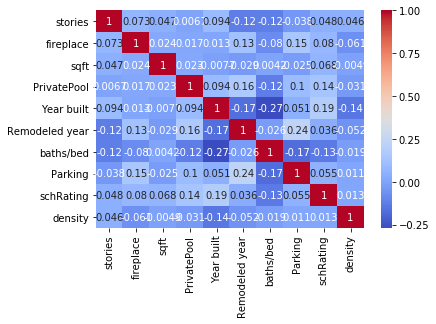

In [117]:
sns.heatmap(Features.corr(), annot=True, cmap='coolwarm')

# Model

In [118]:
import numpy as np
from sklearn.metrics import mean_absolute_error,mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [119]:
scaler = StandardScaler()
FeaturesSt=scaler.fit_transform(Features)

In [120]:
X_train, X_test, y_train, y_test = train_test_split(FeaturesSt, target, test_size=0.2)
print('X_train:', X_train.shape)
print('X_test:', X_test.shape)
print('y_train:', y_train.shape)
print('y_test:', y_test.shape)

X_train: (149164, 10)
X_test: (37291, 10)
y_train: (149164,)
y_test: (37291,)


In [121]:
start = timer()
predictor = GradientBoostingRegressor(n_estimators=1000, learning_rate=0.4)
predictor.fit(X_train, y_train)
y_pred = predictor.predict(X_test)
end = timer()
print(end - start)

157.11193379999997


In [122]:
mae=mean_absolute_error(y_test,y_pred)
mse=mean_squared_error(y_test,y_pred)
print(f'R^2 GB: {round(predictor.score(X_test,y_test),4)}, MAE GB: {round(mae,2)}, RSME: {round(np.sqrt(mse),2)}')


R^2 GB: 0.9692, MAE GB: 0.07, RSME: 0.1


The model is not perfect and requires some further work with the data. 